In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.chdir("/home/jovyan/work/Face_Mask_Detection")
!pwd

/home/jovyan/work/Face_Mask_Detection


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses, initializers
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import pandas as pd
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import utils
from tensorflow.keras.applications.vgg19 import VGG19

In [3]:
physical_gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)

# Start

In [4]:
labels = ("without_mask", "with_mask")
train_dir = "dataset/train"
val_dir = "dataset/valid"
test_dir = "dataset/test"

ImageDataGenerator詳細：https://zhuanlan.zhihu.com/p/30197320

In [5]:
train_datagen = ImageDataGenerator(rescale=1/255)
val_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_dir, batch_size=100, class_mode="binary", target_size=(96, 96))
validation_generator = val_datagen.flow_from_directory(val_dir, batch_size=20, class_mode="binary", target_size=(96, 96))

train_num = 3161

Found 3161 images belonging to 2 classes.
Found 394 images belonging to 2 classes.


加載VGG19預訓練模型：https://blog.csdn.net/dcrmg/article/details/81178424

layers len = 22


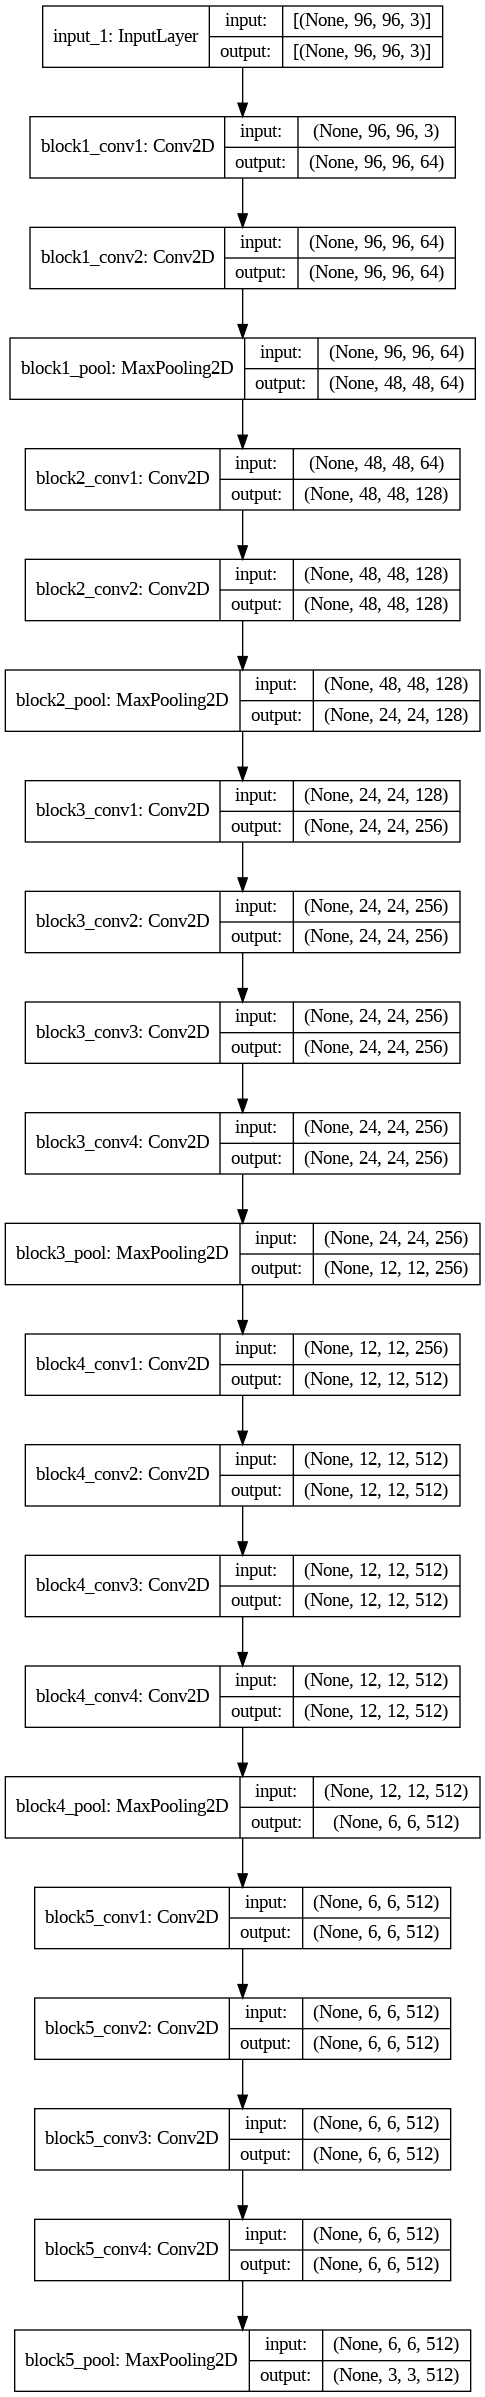

In [6]:
base_model = VGG19(weights="imagenet", input_shape=(96, 96, 3), include_top=False)
print(f"layers len = {len(base_model.layers)}")
for layer in base_model.layers:
    layer.trainable = False
plot_model(base_model, show_shapes=True)

如何去掉模型的全連接層：https://blog.csdn.net/qq_29462849/article/details/83010854

In [7]:
model = keras.Sequential([
    base_model,
    layers.Flatten(),
    # layers.BatchNormalization(),
    # layers.Dense(4096, activation="relu", kernel_initializer="he_normal"),
    # layers.Dropout(0.2),
    # layers.Dense(4096, activation="relu", kernel_initializer="he_normal"),
    # layers.Dropout(0.2),
    layers.Dense(1000, activation="relu", kernel_initializer="he_normal"),
    # layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
])
model.summary()
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics="binary_accuracy"
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 3, 3, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 1000)              4609000   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1001      
Total params: 24,634,385
Trainable params: 4,610,001
Non-trainable params: 20,024,384
_________________________________________________________________


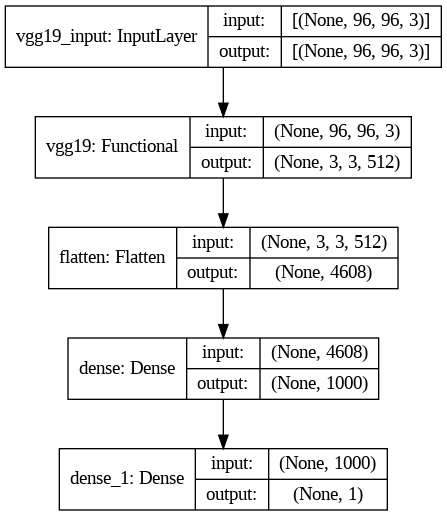

In [8]:
plot_model(model, show_shapes=True)

ReduceLROnPlateau待測試：https://hackmd.io/@allen108108/SyCsOIkxB

In [10]:
model_tag = 'vgg19'
models_dir = 'models'
model_dir = os.path.join(models_dir, model_tag)
callbacks = []
''' EarlyStopping '''
callbacks.append(
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, verbose=1, mode="auto")
)
''' ModelCheckpoint '''
model_name = 'model.h5'
filepath = os.path.join(model_dir, model_name)
callbacks.append(
    keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
)
''' ModelCheckpoint '''
model_name = 'epoch_{epoch:03d}-val_loss_{val_loss:.3f}.h5'
filepath = os.path.join(model_dir, "checkpoint", model_name)
callbacks.append(
    keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
)
''' TensorBoard '''
log_dir = os.path.join(models_dir, 'logs', model_tag)
callbacks.append(
  keras.callbacks.TensorBoard(log_dir=log_dir)
)
''' trainParam '''
batch_size = 1000
epochs = 1000
steps_per_epoch = int(train_num / batch_size)
print(f'steps_per_epoch = {steps_per_epoch}')
print(f'filepath = {filepath}')

steps_per_epoch = 3
filepath = models/vgg19/checkpoint/epoch_{epoch:03d}-val_loss_{val_loss:.3f}.h5


# Train

In [11]:
trainHistory = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/1000
3/3 [==============================] - 113s 37s/step - loss: 1.7479 - binary_accuracy: 0.6983 - val_loss: 1.1925 - val_binary_accuracy: 0.8198
Epoch 2/1000
3/3 [==============================] - 1s 266ms/step - loss: 0.7385 - binary_accuracy: 0.8121 - val_loss: 0.7913 - val_binary_accuracy: 0.5787
Epoch 3/1000
3/3 [==============================] - 1s 253ms/step - loss: 0.6607 - binary_accuracy: 0.6783 - val_loss: 0.6597 - val_binary_accuracy: 0.8198
Epoch 4/1000
3/3 [==============================] - 1s 245ms/step - loss: 0.5896 - binary_accuracy: 0.8204 - val_loss: 0.4018 - val_binary_accuracy: 0.8198
Epoch 5/1000
3/3 [==============================] - 1s 258ms/step - loss: 0.2940 - binary_accuracy: 0.8696 - val_loss: 0.3757 - val_binary_accuracy: 0.8173
Epoch 6/1000
3/3 [==============================] - 1s 239ms/step - loss: 0.3755 - binary_accuracy: 0.8054 - val_loss: 0.2649 - val_binary_accuracy: 0.8756
Epoch 7/1000
3/3 [==============================] - 1s 239ms/ste

# Result

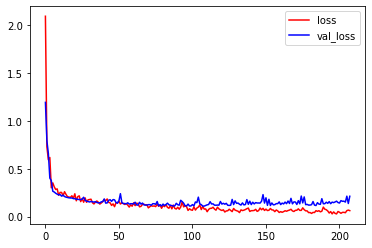

In [12]:
plt.plot(trainHistory.history['loss'], color='r', label='loss')
plt.plot(trainHistory.history['val_loss'], color='b', label='val_loss')
plt.legend()
plt.show()

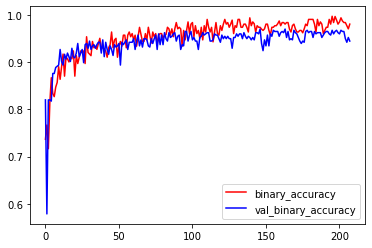

In [13]:
plt.plot(trainHistory.history['binary_accuracy'], color='r', label='binary_accuracy')
plt.plot(trainHistory.history['val_binary_accuracy'], color='b', label='val_binary_accuracy')
plt.legend()
plt.show()

# Test

In [14]:
best_model = load_model(f"models/{model_tag}/model.h5")

In [15]:
test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory(test_dir, shuffle=False, batch_size=406, class_mode="binary", target_size=(96, 96))
Y_test_classes = test_generator[0][1]

Found 394 images belonging to 2 classes.


In [16]:
loss, acc = best_model.evaluate(test_generator)
print(f"ACC = {acc * 100:.4f} %")

1/1 [==============================] - 49s 49s/step - loss: 0.0963 - binary_accuracy: 0.9594
ACC = 95.9391 %


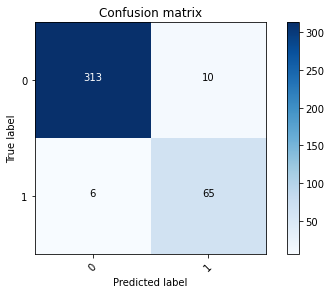

In [17]:
predicts = best_model.predict(test_generator)
predicts_classes = predicts >= 0.5
utils.plot_confusion_matrix(Y_test_classes, predicts_classes, 2)